In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna
from sklearn.metrics import f1_score

c:\Users\HyeonJinLee\Documents\dev\Upstage_AI_LAB_ML_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
with open('./src/train.csv') as f:
    train = pd.read_csv(f)
with open('./src/test.csv') as f:
    test = pd.read_csv(f)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            10000 non-null  object 
 1   subscription_duration              10000 non-null  int64  
 2   recent_login_time                  10000 non-null  int64  
 3   average_login_time                 10000 non-null  float64
 4   average_time_per_learning_session  10000 non-null  float64
 5   monthly_active_learning_days       10000 non-null  int64  
 6   total_completed_courses            10000 non-null  int64  
 7   recent_learning_achievement        10000 non-null  float64
 8   abandoned_learning_sessions        10000 non-null  int64  
 9   community_engagement_level         10000 non-null  int64  
 10  preferred_difficulty_level         10000 non-null  object 
 11  subscription_type                  10000 non-null  obje

In [5]:
train.head(5)

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1


In [6]:
# col = 'preferred_difficulty_level'
# plt.figure(figsize = (6,6))
# sns.countplot(data = train, x = col, hue = 'target', palette = 'Set3')
# plt.savefig(f'{col}.png')

In [7]:
train = train.drop(columns='user_id')
test = test.drop(columns = 'user_id')
train

,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,22,29,14.727623,84.053558,18,16,64.966803,2,5,Low,Premium,1,1,1
9996,10,11,19.374054,45.464833,9,8,82.750244,3,3,Medium,Basic,2,7,1
9997,7,27,18.240978,127.302411,24,14,81.567839,3,5,High,Basic,1,6,1
9998,11,7,18.783800,5.297234,10,10,89.885656,4,5,Low,Basic,2,0,1


In [8]:
# 근 3개월 간 구독 개월
# train.payment_pattern = train.payment_pattern.apply(lambda x: 0 if x == 0 else (1 if x in [1,2,4] else (2 if x in [3,5,6] else 3)))

# 근 1개월 구독 여부
# train.payment_pattern = train.payment_pattern.apply(lambda x: 0 if x in [0,2,4,6] else 1)

# 선호 학습 난이도 (high / basic,low)
# train.preferred_difficulty_level = train.preferred_difficulty_level.apply(lambda x: 1 if x == 'High' else 0)

In [9]:

train.payment_pattern = train.payment_pattern.astype('object', copy = False)
test.payment_pattern = test.payment_pattern.astype('object')
train.payment_pattern.value_counts()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   subscription_duration              10000 non-null  int64  
 1   recent_login_time                  10000 non-null  int64  
 2   average_login_time                 10000 non-null  float64
 3   average_time_per_learning_session  10000 non-null  float64
 4   monthly_active_learning_days       10000 non-null  int64  
 5   total_completed_courses            10000 non-null  int64  
 6   recent_learning_achievement        10000 non-null  float64
 7   abandoned_learning_sessions        10000 non-null  int64  
 8   community_engagement_level         10000 non-null  int64  
 9   preferred_difficulty_level         10000 non-null  object 
 10  subscription_type                  10000 non-null  object 
 11  customer_inquiry_history           10000 non-null  int6

In [10]:
# train['customer_activity_score'] = train.customer_inquiry_history * train.community_engagement_level
# train['monthly_active_time'] = train.monthly_active_learning_days * train.average_login_time
# train['monthly_num_of_session'] = train.monthly_active_time / train.average_time_per_learning_session

# Q1 = train['monthly_num_of_session'].quantile(0.25)
# Q3 = train['monthly_num_of_session'].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# train = train[(train['monthly_num_of_session'] >= lower_bound) & (train['monthly_num_of_session'] <= upper_bound)]

In [11]:
# # 특정 컬럼들에 대한 이상치 확인 (이상치가 있는 컬럼들을 리스트로 지정)
# columns_of_interest = ['average_login_time', 'total_completed_courses', 'recent_learning_achievement','abandoned_learning_sessions','customer_inquiry_history']  # 실제 컬럼 이름에 맞게 수정
# # 각 컬럼에 대해 이상치를 제외한 나머지 행 유지
# for column in columns_of_interest:
#     Q1 = train[column].quantile(0.25)
#     Q3 = train[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     train = train[(train[column] >= lower_bound) & (train[column] <= upper_bound)]
# # 결과 출력
# print("제거 전 행의 개수:", len(pd.read_csv('./src/train.csv')))
# print("제거 후 행의 개수:", len(train))

In [12]:
cols = list(train.columns)
cols.remove('target')
cols

['subscription_duration',
 'recent_login_time',
 'average_login_time',
 'average_time_per_learning_session',
 'monthly_active_learning_days',
 'total_completed_courses',
 'recent_learning_achievement',
 'abandoned_learning_sessions',
 'community_engagement_level',
 'preferred_difficulty_level',
 'subscription_type',
 'customer_inquiry_history',
 'payment_pattern']

In [13]:

X = train.loc[:,['average_time_per_learning_session','recent_learning_achievement','average_login_time']]
# X = train.loc[:,cols]
y = train.loc[:,'target']
X = pd.get_dummies(X)

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=39)

In [20]:
def optimizer1(trial, X, y, K):
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)
    learning_rate = trial.suggest_float('learning_rate',0.01, 0.3)
    # num_leaves = trial.suggest_categorical('num_leaves',[255, 511,1023,2047,4095])
    # colsample_bytree = trial.suggest_float('colsample_bytree',0.5,0.8)
    # reg_lambda = trial.suggest_float('reg_lambda',0.5,200)
    # min_child_samples = trial.suggest_int('min_child_samples',5,50)

    model = LGBMClassifier(n_estimators = n_estimators,
                          learning_rate = learning_rate,
                          max_depth = 15,
                          colsample_bytree = 0.5000263102652682,
                          num_leaves= 511,
                          min_child_samples= 21,
                          reg_lambda = 10.196712114510644,
                          random_state = 39,
                          objective = 'binary',
                          verbose  = -1)
    
    kf = StratifiedKFold(n_splits = K, random_state=39, shuffle=True)
    macrof1 = []
    for idx, (train_idx, val_idx) in enumerate(kf.split(X,y)):
        X_train = X.iloc[train_idx,:]
        X_val = X.iloc[val_idx,:]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        macrof1.append(f1_score(y_val, prediction, average= 'macro'))
    
    return np.mean(macrof1)

In [15]:
def optimizer2(trial, X, y, K):
    n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    learning_rate = trial.suggest_float('learning_rate',0.01, 0.3)
    max_depth = trial.suggest_int('max_depth',5,13)
    colsample_bynode = trial.suggest_float('colsample_bynode',0.5,0.8)
    reg_lambda = trial.suggest_float('reg_lambda',0.5,200)

    model = XGBClassifier(n_estimators = n_estimators,
                          learning_rate = learning_rate,
                          max_depth = max_depth,
                          colsample_bynode = colsample_bynode,
                          reg_lambda = reg_lambda,
                          random_state = 39,
                          verbosity  = 0)
    
    kf = StratifiedKFold(n_splits = K, random_state=39, shuffle=True)
    macrof1 = []
    for idx, (train_idx, val_idx) in enumerate(kf.split(X,y)):
        X_train = X.iloc[train_idx,:]
        X_val = X.iloc[val_idx,:]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        macrof1.append(f1_score(y_val, prediction, average= 'macro'))
    
    return np.mean(macrof1)

In [21]:
K = 5
opt_func = partial(optimizer1, X = X, y = y, K = K)
study = optuna.create_study(direction = 'maximize')
study.optimize(opt_func, n_trials = 100)

print(f"best score : {study.best_value:.4f}")
print(f"best params : {study.best_params}")




[I 2023-12-06 16:40:55,803] A new study created in memory with name: no-name-500d4a51-964a-42b1-9640-3b2080023fb8
[I 2023-12-06 16:41:45,450] Trial 0 finished with value: 0.517645425800891 and parameters: {'n_estimators': 1648, 'learning_rate': 0.060799443336264566}. Best is trial 0 with value: 0.517645425800891.
[I 2023-12-06 16:42:21,445] Trial 1 finished with value: 0.5157024805489374 and parameters: {'n_estimators': 1169, 'learning_rate': 0.2092239939748187}. Best is trial 0 with value: 0.517645425800891.
[I 2023-12-06 16:42:34,113] Trial 2 finished with value: 0.5147082700808181 and parameters: {'n_estimators': 439, 'learning_rate': 0.20273942075746088}. Best is trial 0 with value: 0.517645425800891.
[I 2023-12-06 16:43:08,941] Trial 3 finished with value: 0.5111824228099368 and parameters: {'n_estimators': 1299, 'learning_rate': 0.057920994791519125}. Best is trial 0 with value: 0.517645425800891.
[I 2023-12-06 16:44:03,051] Trial 4 finished with value: 0.5191795700187812 and par

best score : 0.5232
best params : {'n_estimators': 1604, 'learning_rate': 0.2854734948947413}


### study 1

best : 0.5228

best params : {'n_estimators': 1790, 'learning_rate': 0.2931348491046597, 'num_leaves': 1023, 'colsample_bytree': 0.6101546050708754, 'reg_lambda': 10.09474405737206, 'min_child_samples': 28}

### study 2 (fix learning rate) **BEST ONE**

best score : 0.5251

best params : {'learning_rate':0.2931348491046597,'n_estimators': 1425, 'num_leaves': 511, 'colsample_bytree': 0.5000263102652682, 'reg_lambda': 10.196712114510644, 'min_child_samples': 21}

### study 3 (fix learning rate, n_estimators)

best score : 0.5239

best params : {'learning_rate':0.2931348491046597,'n_estimators': 1425, 'num_leaves': 2047, 'colsample_bytree': 0.5181718302148206, 'reg_lambda': 5.1278966572882805, 'min_child_samples': 24}

### study 4 (only learning rate & n_estimators)

best score : 0.5232

best params : {'n_estimators': 1604, 'learning_rate': 0.2854734948947413}




In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
best_params = study.best_params
# best_params = {'n_estimators': 991, 'learning_rate': 0.23374124738460758, 'num_leaves': 4095, 'colsample_bytree': 0.6985326853347374, 'reg_lambda': 33.918951615552224, 'min_child_samples': 17}

In [ ]:
best_params = {'n_estimators': 1575,
 'learning_rate': 0.2967560328145525,
 'num_leaves': 1023,
 'colsample_bytree': 0.6196248925840157,
 'reg_lambda': 0.9547642403311936,
 'min_child_samples': 29}

{'n_estimators': 1575,
 'learning_rate': 0.2967560328145525,
 'num_leaves': 1023,
 'colsample_bytree': 0.6196248925840157,
 'reg_lambda': 0.9547642403311936,
 'min_child_samples': 29}

In [ ]:
# n_estimators = 200, colsample_bynode = 0.8, max_depth = 13, learning_rate = 0.3, reg_lambda = 1
model1 = XGBClassifier(n_estimators= 1729,
                      learning_rate= 0.26962375010754236,
                      max_depth= 6,
                      colsample_bynode= 0.6800192128540902,
                      reg_lambda= 153.79087269756306)

model2 = LGBMClassifier(**best_params,
                        max_depth = 15,
                        random_state=39,
                        verbose = -1)
model3 = LGBMClassifier(n_estimators= 1000,
                        learning_rate = 0.15,
                        max_depth = 15,
                        num_leaves= 2047,
                        min_child_samples= 10,
                        colsample_bytree = 0.75,
                        reg_lambda= 1,
                        random_state=39,
                        verbose = -1)
K = 5
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=39)
macrof1 = []
feat_imp = []
X_copy = X.copy()
# X_copy = X_copy.drop(columns = ['preferred_difficulty_level_High','preferred_difficulty_level_Low','preferred_difficulty_level_Medium','payment_pattern','total_completed_courses','abandoned_learning_sessions','subscription_type_Basic','subscription_type_Premium'])
# X_copy = X_copy[['average_login_time','average_time_per_learning_session']]


fold : 0
fold : 1
fold : 2
fold : 3
fold : 4


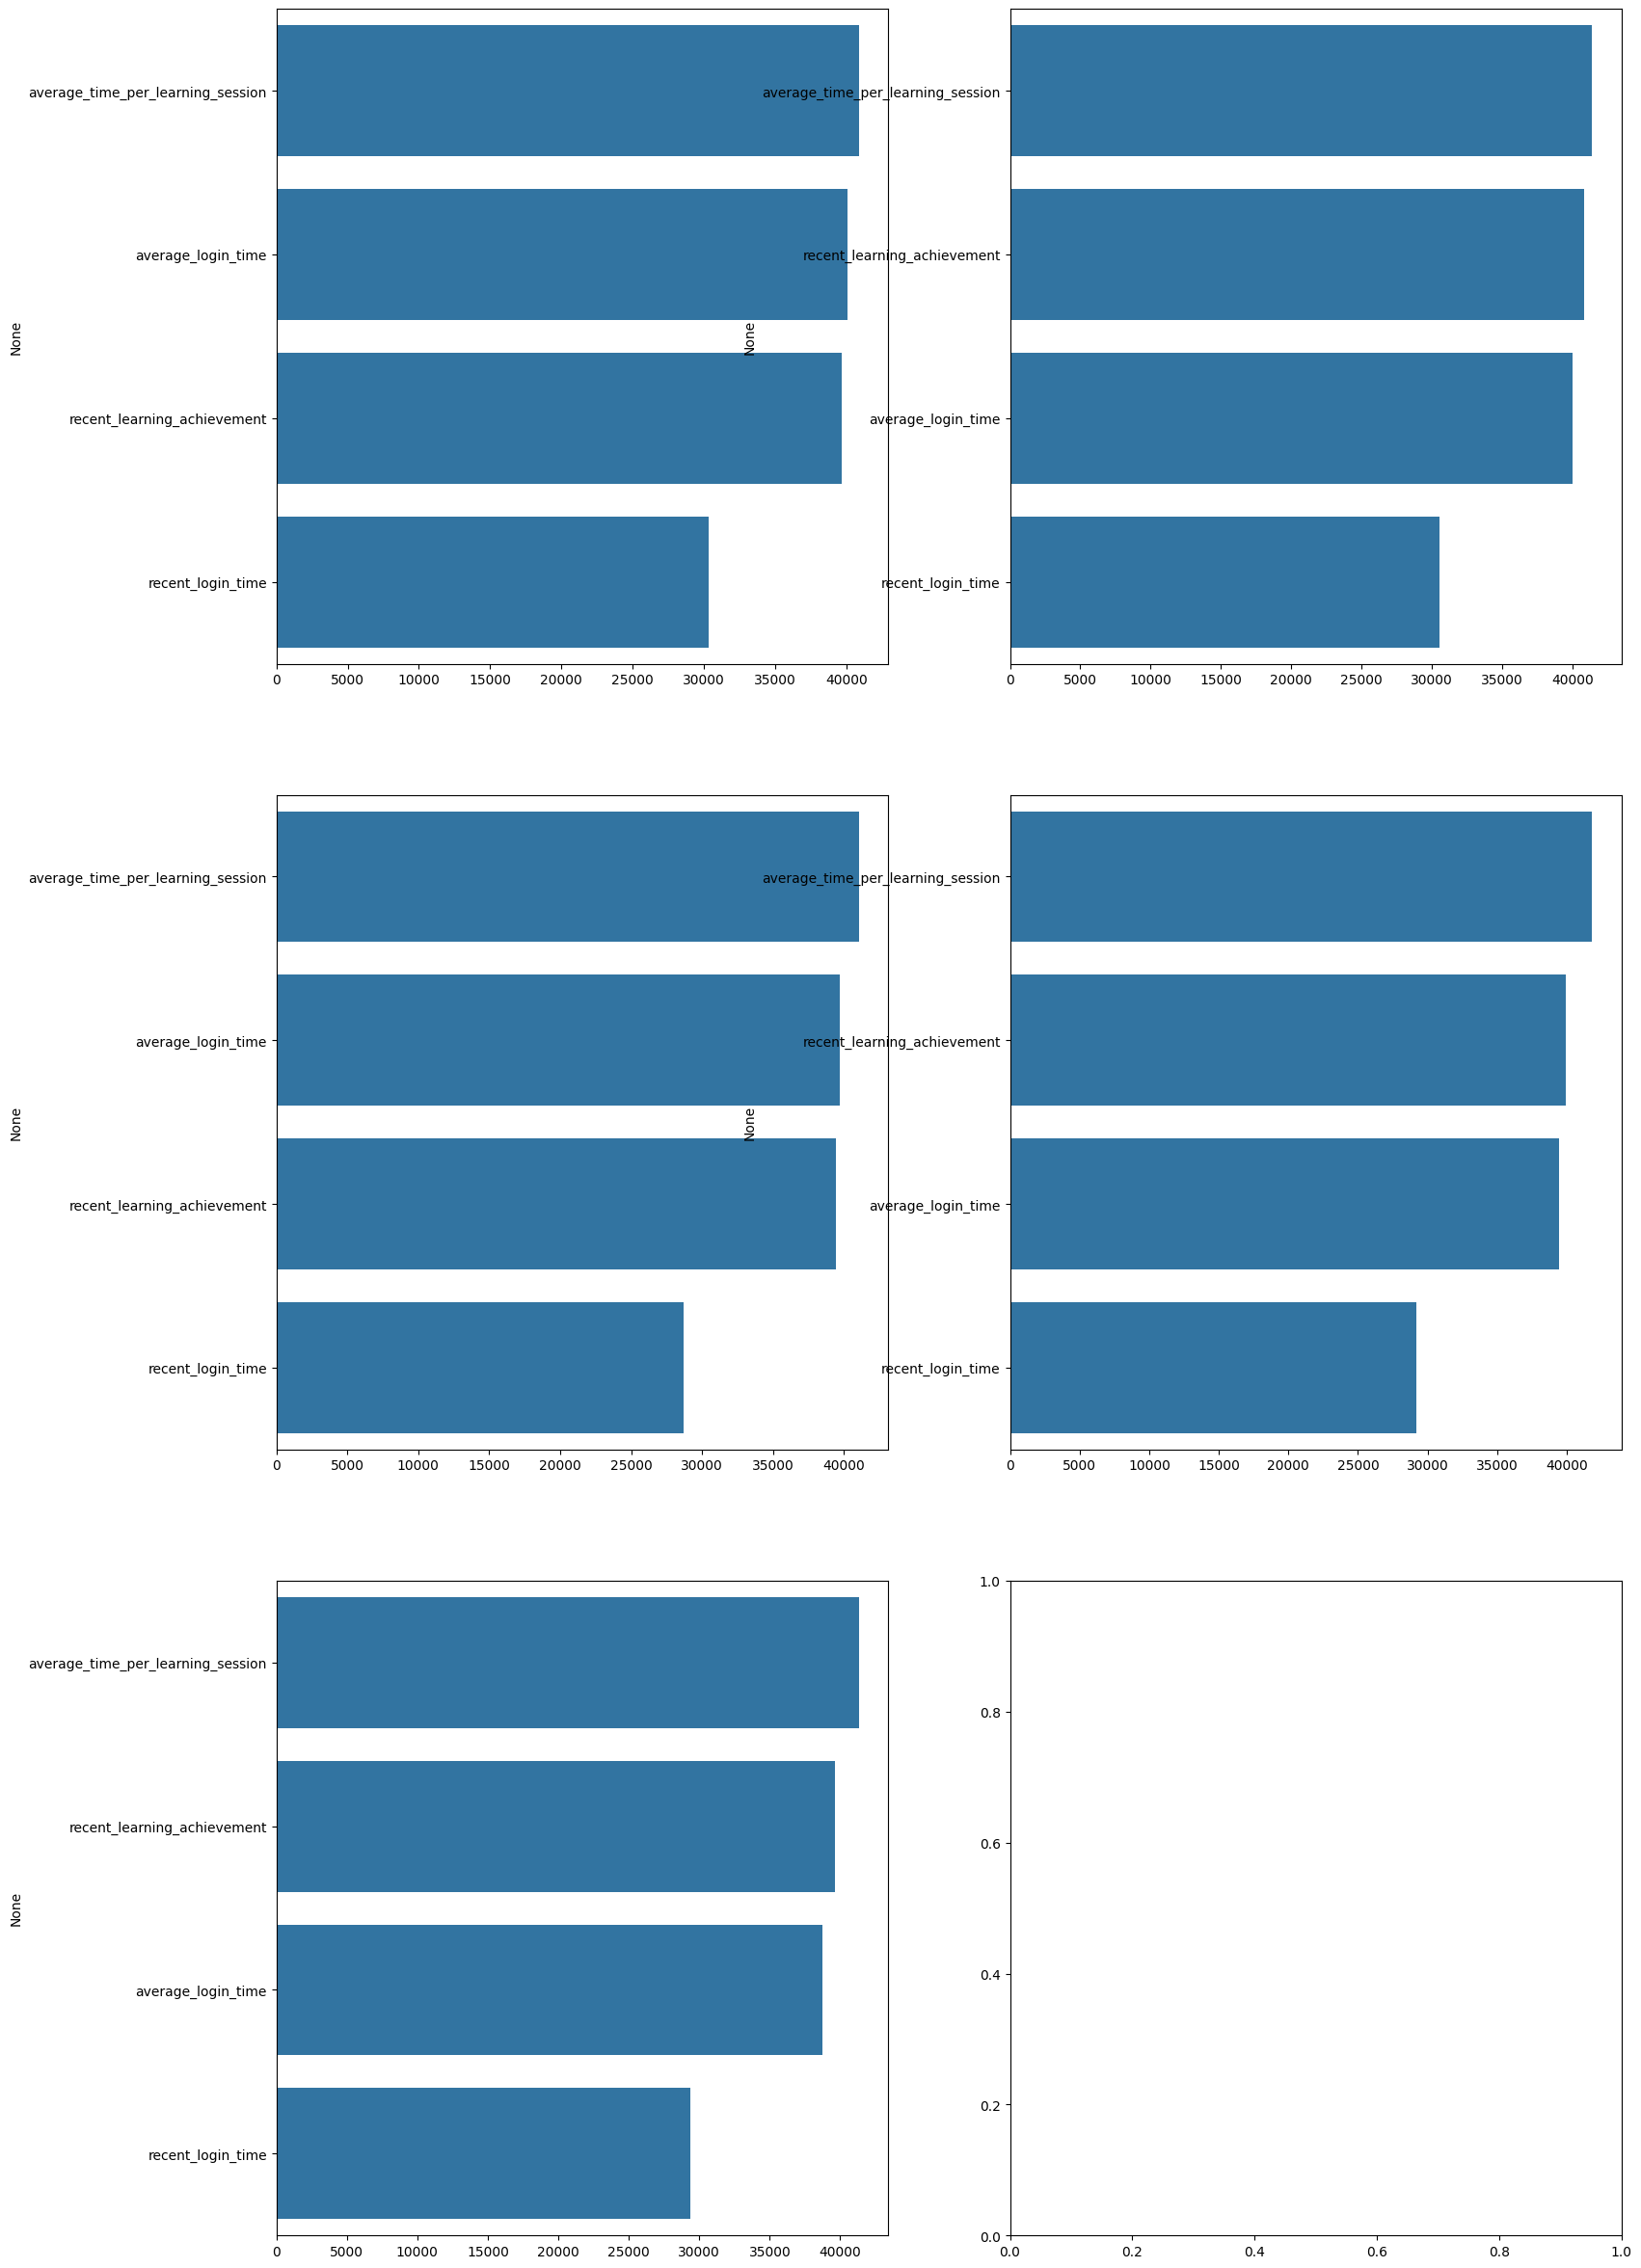

[0.5208070617906684, 0.5110488367340982, 0.5185712071604823, 0.5147901621649404, 0.5191701411474215]
macro f1 score : 0.5168774817995223


,feat,imp
0,average_time_per_learning_session,41292.0
1,recent_learning_achievement,39886.6
2,average_login_time,39599.8
3,recent_login_time,29638.4


In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (18, 30))
for idx, (train_idx, val_idx) in enumerate(kf.split(X_copy, y)):
    print(f"fold : {idx}")
    X_train = X_copy.iloc[train_idx,:]
    X_val = X_copy.iloc[val_idx,:]
    y_train = y.iloc[train_idx]
    y_val = y.iloc[val_idx]

    class_0_count = (y_train == 0).sum()
    class_1_count = (y_train == 1).sum()
    weight_value = class_0_count / class_1_count
    model2.set_params(scale_pos_weight = weight_value)

    model2.fit(X_train, y_train)
    prediction = model2.predict(X_val)
    macrof1.append(f1_score(y_val, prediction, average = 'macro'))
    feat_imp.append(model2.feature_importances_)
    tmp = pd.DataFrame({'idx': X_copy.columns, 'imp' : model2.feature_importances_})
    tmp = tmp.sort_values(by = 'imp', ascending = False)
    sns.barplot(y = X_train.columns,x =  model2.feature_importances_, ax = ax[idx//2][idx%2], order = tmp['idx'])
plt.show()
print(macrof1)
print(f"macro f1 score : {np.mean(macrof1)}")
pd.DataFrame({'feat': X_train.columns, 'imp' : sum(feat_imp)/K}).sort_values(by = 'imp', ascending=False)

        

In [ ]:
with open('./src/sample_submission.csv') as f:
    submission = pd.read_csv(f)
best_params = {'learning_rate':0.2931348491046597,'n_estimators': 1425, 'num_leaves': 511, 'colsample_bytree': 0.5000263102652682, 'reg_lambda': 10.196712114510644, 'min_child_samples': 21}
model = LGBMClassifier(**best_params, random_state = 39)
model.fit(X, y)
pred = model.predict(pd.get_dummies(test[['average_time_per_learning_session','recent_learning_achievement','average_login_time']]))
submission.target = pred
submission.to_csv('./src/submission.csv', index=False)

[LightGBM] [Info] Number of positive: 6199, number of negative: 3801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.619900 -> initscore=0.489124
[LightGBM] [Info] Start training from score 0.489124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes